In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


['mnist_train.csv', 'mnist_test.csv']


In [2]:
train = pd.read_csv('../input/mnist_train.csv')
test = pd.read_csv('../input/mnist_test.csv')

In [3]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,:1]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,:1]

In [4]:
#we don't use labels now

# y_train.columns=['labels']
# y_test.columns = ['labels']
# y_train.labels.value_counts(normalize=True), y_test.labels.value_counts(normalize=True)


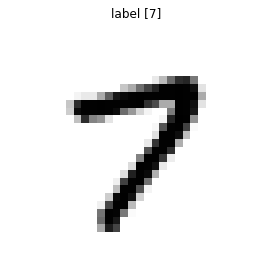

In [5]:
num = np.random.randint(60000)
some_digit = X_train.values[num]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary,
           interpolation="nearest"
          )
plt.axis("off")
plt.title('label {}'.format(y_train.values[num]))
plt.show()

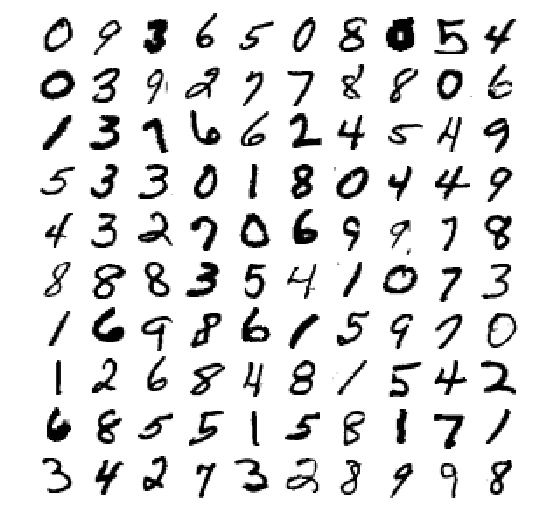

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

plt.show()

In [7]:
#normalize values
X_train = X_train.astype('float32')/ 255.
X_test=X_test.astype('float32')/255.

In [26]:
from tensorflow.python.eager import context
from tensorflow.python.framework import common_shapes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import InputSpec
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import standard_ops
import tensorflow as tf

class DenseTied(Layer):

    def __init__(self,
                 units,
                 activation=None,
                 use_bias=True,
                 # kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 # kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 # kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(DenseTied, self).__init__(
            activity_regularizer=regularizers.get(activity_regularizer), **kwargs)
        self.tied_to = tied_to
        self.units = int(units)
        self.activation = activations.get(activation)

        """transposed weights are variables and don't use any regularizators or initizlizators"""
        # self.kernel_initializer = None
        # self.kernel_constraint = None  
        # self.kernel_regularizer = None 

        """biases are still initialized and regularized"""
        self.use_bias = use_bias
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)
        self.supports_masking = True
        self.input_spec = InputSpec(min_ndim=2)

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if input_shape[-1].value is None:
            raise ValueError('The last dimension of the inputs to `Dense` '
                             'should be defined. Found `None`.')
        self.input_spec = InputSpec(min_ndim=2,
                                    axes={-1: input_shape[-1].value})

        """Get and transpose tied weights 
        Caution: <weights> method returns array of arrays with kernels and biases and use only kernels here"""

        if isinstance(self.tied_to, str):
            # if <tied_to> is str i.e. tf layer name
            try:
                weights = model.get_layer("{}".format(self.tied_to)).weights[0] 
            except:
                weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "{}".format(self.tied_to))[0]
            self.transposed_weights = tf.transpose(weights, name='{}_kernel_transpose'.format(self.tied_to))

        else:
            # if <tied_to> is layer variable
            weights = self.tied_to.weights[0]
            self.transposed_weights = tf.transpose(weights, name='{}_kernel_transpose'.format(self.tied_to.name))


        if self.use_bias:
            self.bias = self.add_weight(
                'bias',
                shape=[self.units, ],
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                dtype=self.dtype,
                trainable=True)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs):

        inputs = ops.convert_to_tensor(inputs, dtype=self.dtype)
        rank = common_shapes.rank(inputs)
        if rank > 2:
            # Broadcasting is required for the inputs.
            outputs = standard_ops.tensordot(inputs, self.transposed_weights, [[rank - 1], [0]])
            # Reshape the output back to the original ndim of the input.
            if not context.executing_eagerly():
                shape = inputs.get_shape().as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(output_shape)
        else:
            outputs = gen_math_ops.mat_mul(inputs, self.transposed_weights)
        if self.use_bias:
            outputs = nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)  # pylint: disable=not-callable
        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if input_shape[-1].value is None:
            raise ValueError(
                'The innermost dimension of input_shape must be defined, but saw: %s'
                % input_shape)
        return input_shape[:-1].concatenate(self.units)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(DenseTied, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
from tensorflow.python import keras
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense,Flatten,Input,Dropout

In [10]:
tf.reset_default_graph()

In [11]:
n_inputs = 28*28
n_hidden1 = 256
n_hidden2 = 64  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

input_img = Input(shape = (n_inputs, ))

#encoding
dense1 = Dense(n_hidden1, activation='relu', name='layer_1')
d1 = dense1(input_img)

dense2 = Dense(n_hidden2, activation='relu', name='layer_2')
d2=dense2(d1)

#decoding
dense3 = DenseTied(n_hidden3, activation='relu', name='tied_layer_2', tied_to = 'layer_2') # tied_to layer name
d3=dense3(d2)

dense4 = DenseTied(n_outputs, activation='relu', name='tied_layer_1', tied_to = dense1) # tied_to layer variable
output=dense4(d3)

model = Model(input_img, output)
model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [12]:
model.summary()
# Only trainable parameters of decoder part (layers dense3 and dense4) are biases

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
layer_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
tied_layer_2 (DenseTied)     (None, 256)               256       
_________________________________________________________________
tied_layer_1 (DenseTied)     (None, 784)               784       
Total params: 218,448
Trainable params: 218,448
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,X_train,
          epochs=100,
          batch_size=256,
          shuffle=True,
          validation_data=(X_test,X_test),
         callbacks = [keras.callbacks.EarlyStopping(patience=20)]
         )

Train on 59999 samples, validate on 9999 samples
Epoch 1/100
59999/59999 [==============================] - 8s 141us/step - loss: 0.1066 - val_loss: 0.1014
Epoch 2/100
59999/59999 [==============================] - 8s 141us/step - loss: 0.1063 - val_loss: 0.1027
Epoch 3/100
59999/59999 [==============================] - 8s 140us/step - loss: 0.1048 - val_loss: 0.1023
Epoch 4/100
59999/59999 [==============================] - 8s 140us/step - loss: 0.1091 - val_loss: 0.1083
Epoch 5/100
59999/59999 [==============================] - 8s 140us/step - loss: 0.1152 - val_loss: 0.1095
Epoch 6/100
59999/59999 [==============================] - 8s 140us/step - loss: 0.1054 - val_loss: 0.1061
Epoch 7/100
59999/59999 [==============================] - 8s 140us/step - loss: 0.1095 - val_loss: 0.1074
Epoch 8/100
59999/59999 [==============================] - 8s 139us/step - loss: 0.1046 - val_loss: 0.0989
Epoch 9/100
59999/59999 [==============================] - 8s 139us/step - loss: 0.1075 - val_l

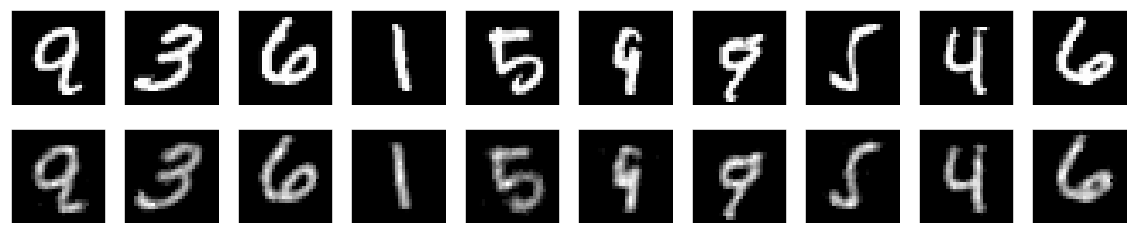

In [23]:
#visualize reconstructions
%matplotlib inline
import random
n = 10  # how many digits will be displayed

images = np.random.choice(range(len(X_test)), n) 
x_test = X_test.values[images]

decoded_imgs = model.predict(x_test)


plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap = matplotlib.cm.binary,
           interpolation="nearest")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28),cmap = matplotlib.cm.binary,
           interpolation="nearest")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

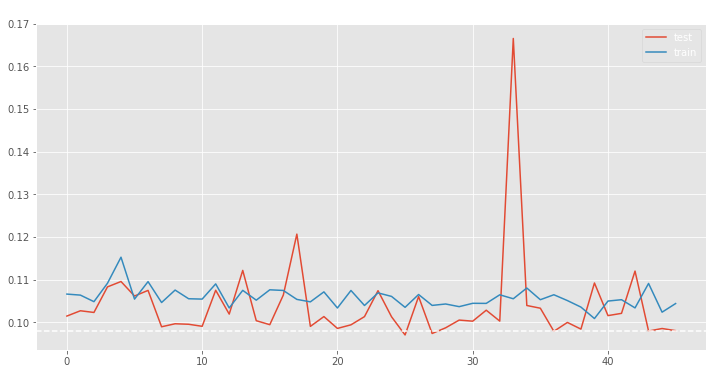

In [25]:
hist = model.history
from matplotlib import style
style.use('ggplot')
def show_results(hists):
    for i, hist in enumerate(hists):
        plt.figure(figsize=(12,6))
        loss=hist.history['loss']
        test_loss=hist.history['val_loss']
        epochs=range(len(loss))
        plt.plot(epochs,test_loss,label='test')
        plt.plot(epochs,loss,label='train')
        plt.axhline(y=test_loss[-1],linestyle='--')

        plt.legend()
        plt.title('Loss_{}'.format(i))
show_results([hist])